In [16]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
warnings.filterwarnings('ignore')

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")
            
class Params:
    def __init__(self):
        self.batch_size = 96
        self.workers = 4
        self.momentum = 0.9
        self.weight_decay = 4e-5
        self.lr_step_size = 50
        self.lr_gamma = 0.1
        self.alpha = 0.3
        self.beta = 0.3
        self.gamma = 0.2
        self.delta = 0.2
        self.temperature = 3.0
        self.num_epochs = 100
        self.learning_rate = 0.1

    def __repr__(self):
        return str(self.__dict__)
    
    def __eq__(self, other):
        return self.__dict__ == other.__dict__

params = Params()

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(0.5),       
    transforms.ToTensor(),    
    transforms.Normalize((0.5070754, 0.48655024, 0.44091907), (0.26733398, 0.25643876, 0.2761503))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5070754, 0.48655024, 0.44091907), (0.26733398, 0.25643876, 0.2761503))
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Using mps device
Files already downloaded and verified
Files already downloaded and verified


In [17]:
from torch.nn.functional import cosine_similarity

class DistillationLoss(nn.Module):
    def __init__(self, alpha, temperature):
        super(DistillationLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, targets):
        student_loss = self.criterion(student_logits, targets)
        
        distillation_loss = F.kl_div(
            F.log_softmax(student_logits / self.temperature, dim=1),
            F.softmax(teacher_logits / self.temperature, dim=1),
            reduction='batchmean'
        ) * (self.temperature ** 2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

def normalize(logit):
    mean = logit.mean(dim=-1, keepdims=True)
    stdv = logit.std(dim=-1, keepdims=True)
    return (logit - mean) / (1e-7 + stdv)
    
class CorrLoss(nn.Module):
    def __init__(self, alpha=3.0, beta=3.0, gamma=2.0, delta=2.0, tau=1.0, eps=1e-8):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.tau = tau
        self.eps = eps
        self.temperature = 3.0
        self.criterion = nn.CrossEntropyLoss()

    def pearson_correlation(self, y_s, y_t, eps):
        return cosine_similarity(y_s - y_s.mean(1).unsqueeze(1), y_t - y_t.mean(1).unsqueeze(1), eps=eps)

    def inter_class_relation(self, y_s, y_t):
        return 1 - self.pearson_correlation(y_s, y_t, self.eps).mean()

    def intra_class_relation(self, y_s, y_t):
        return self.inter_class_relation(y_s.transpose(0, 1), y_t.transpose(0, 1))

    def forward(self, student_logits, teacher_logits, targets):
        student_logits = normalize(student_logits)
        teacher_logits = normalize(teacher_logits)
        y_s = (student_logits / self.tau).softmax(dim=1)
        y_t = (teacher_logits / self.tau).softmax(dim=1)
        inter_loss = self.tau ** 2 * self.inter_class_relation(y_s, y_t)
        intra_loss = self.tau ** 2 * self.intra_class_relation(y_s, y_t)

        student_loss = self.criterion(student_logits, targets)
        distillation_loss = F.kl_div(
            F.log_softmax(student_logits / self.temperature, dim=1),
            F.softmax(teacher_logits / self.temperature, dim=1),
            reduction='batchmean'
        ) * (self.temperature ** 2)
        loss = self.alpha * student_loss + self.beta * distillation_loss  + self.gamma * inter_loss + self.delta * intra_loss
        
        return loss

In [18]:
def distill(dataloader, teacher, model, epoch):
    size = len(dataloader.dataset)
    model.train()
    # distillation_criterion = DistillationLoss(params.alpha, params.temperature)
    distillation_criterion = CorrLoss()
    optimizer = optim.SGD(student_model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params.lr_step_size, gamma=params.lr_gamma)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            teacher_logits = teacher(X)
        student_logits = model(X)
        loss = distillation_criterion(student_logits, teacher_logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=5.0)
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            print(f"loss: {loss.item():.6f} [{batch * len(X)}/{size}]")

    scheduler.step()

def train(dataloader, teacher, model, max_acc):
    start_epoch = 0
    for epoch in range(start_epoch, params.num_epochs):
        distill(dataloader, teacher, model, epoch)
        acc = test(test_loader, model, nn.CrossEntropyLoss(), epoch)
        # Save checkpoint if greater than current accuracy
        if acc > max_acc + 0.02 and epoch > 20:
            name = './checkpoints/student-' + str(epoch + 1) + '.pth'
            torch.save(student_model.state_dict(), name)
            print("Student model saved as '" + name +  "'")
            max_acc = acc
            print("Setting max accuracy as " + str(max_acc))
            

def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    step = epoch * len(dataloader.dataset)
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct

In [19]:
from student import densenet
from teacher import wide_resnet

teacher_model = wide_resnet().to(device)
teacher_model.eval()
student_model = densenet().to(device)
student_model.load_state_dict(torch.load('./checkpoints/student-65.pth', map_location=device))
student_model.eval()

# COMMENTED AFTER TRAINING COMPLETE
# student_model.train()
# train(train_loader, teacher_model, student_model, 0)

# TEST ACCURACY of TEACHER
print('TEACHER MODEL STATS:')
start_time = time.time()
test(test_loader, teacher_model, nn.CrossEntropyLoss(), 0)
end_time = time.time()
print('Total Time elapsed ', end_time - start_time, ' s')
print('Avg. Time per sample ', (end_time - start_time) / len(test_dataset) * 1000, ' ms')
print(f"Number of trainable parameters: {count_parameters(teacher_model) / 1000000.0} M\n\n")

# TEST ACCURACY of STUDENT
print('STUDENT MODEL STATS:')
start_time = time.time()
test(test_loader, student_model, nn.CrossEntropyLoss(), 0)
end_time = time.time()
print('Total Time elapsed ', end_time - start_time, ' s')
print('Avg. Time per sample ', (end_time - start_time) / len(test_dataset) * 1000, ' ms')
print(f"Number of trainable parameters: {count_parameters(student_model)/ 1000000.0} M")

TEACHER MODEL STATS:
Accuracy: 81.3%, Avg loss: 0.752171
Total Time elapsed  35.66868567466736  s
Avg. Time per sample  3.5668685674667358  ms
Number of trainable parameters: 36.536884 M


STUDENT MODEL STATS:
Accuracy: 77.0%, Avg loss: 0.935294
Total Time elapsed  21.80006694793701  s
Avg. Time per sample  2.1800066947937013  ms
Number of trainable parameters: 0.800032 M


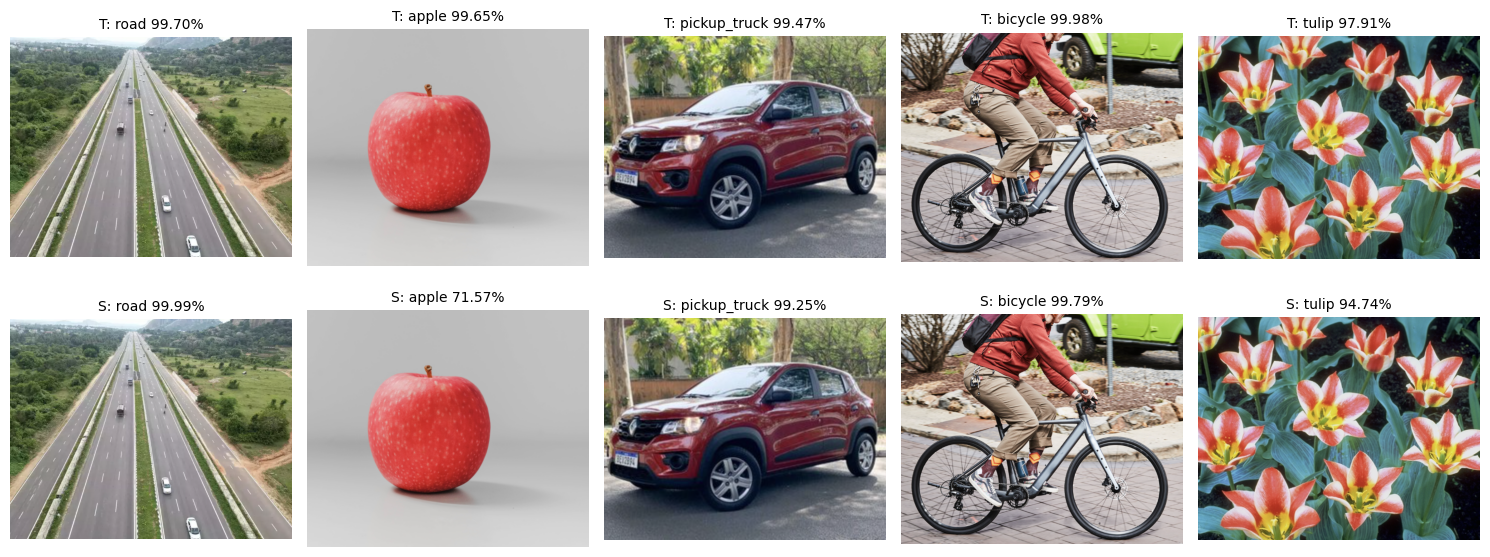

In [20]:
from student import densenet
from teacher import wide_resnet
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

image_folder = './sample_images'
custom_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5070754, 0.48655024, 0.44091907), (0.26733398, 0.25643876, 0.2761503))
])

# Take first 5 images
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]

def predict(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_label = probabilities.argmax(dim=1).item()
        prediction_score = probabilities[0, predicted_label].item() * 100
    return predicted_label, prediction_score

class_names = test_dataset.classes

n_images = len(image_paths)
fig, axes = plt.subplots(2, n_images, figsize=(15, 6))

for i, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert("RGB")
    sample_image = custom_transform(image).unsqueeze(0).to(device)
    
    teacher_label, teacher_score = predict(teacher_model, sample_image)
    student_label, student_score = predict(student_model, sample_image)
    
    unnormalized_image = sample_image.cpu().squeeze().permute(1, 2, 0)
    unnormalized_image = unnormalized_image * torch.tensor((0.2673, 0.2564, 0.2762)) + torch.tensor((0.5071, 0.4865, 0.4409))
    unnormalized_image = unnormalized_image.clip(0, 1).numpy()
    
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"T: {class_names[teacher_label]} {teacher_score:.2f}%", fontsize=10)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(image)
    axes[1, i].set_title(f"S: {class_names[student_label]} {student_score:.2f}%", fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
print(class_names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',